# Time Series analysis


I this notebook I will be analysing the US unemployment data from 2010-2020 using techniques like ARIMA.

In [139]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import config

# get API key from config.py
api_key = config.NASDAQ

nasdaqdatalink.ApiConfig.api_key = api_key

df_unem = (  nasdaqdatalink.get(dataset="FRED/UNRATENSA",
        start_date="2010-01-01",
        end_date="2019-12-31")
        .rename(columns={"Value": "unemp_rate"}))


In [145]:
df.head()

,unemp_rate
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3


<Axes: title={'center': 'Unemployment Rate'}, xlabel='Year', ylabel='Rate'>

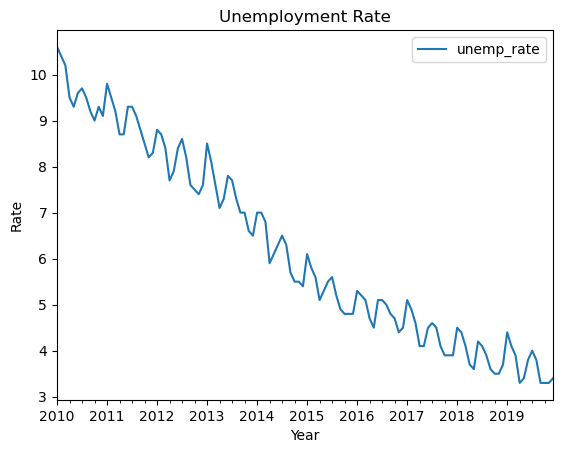

In [142]:
df_unem.plot(title='Unemployment Rate',ylabel='Rate',xlabel='Year')

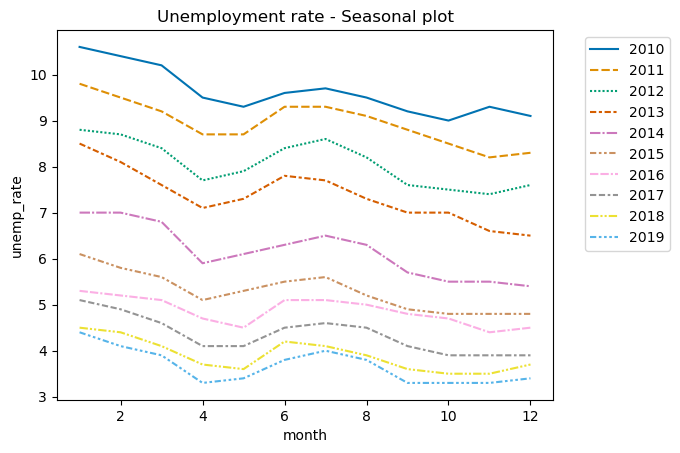

In [158]:
fig,ax = plt.subplots(1,1)
df_unem['month'] = df_unem.index.month
df_unem['year'] = df_unem.index.year

sns.lineplot(data=df_unem, 
             x="month", 
             y="unemp_rate", 
             hue="year",
             style="year", 
             legend="full",
             palette="colorblind")
plt.title("Unemployment rate - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Both over the years and wihtin the months, the unemployment rate has some repeating patterns. I will try to model it.

### Rolling mean and standard deviation

<Axes: title={'center': 'Unemployment rate'}, xlabel='Date'>

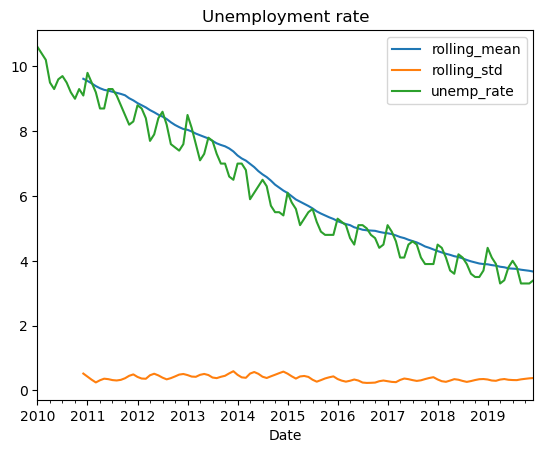

In [160]:

WINDOW_SIZE = 12
df_unem["rolling_mean"] = df_unem["unemp_rate"].rolling(window=WINDOW_SIZE).mean()
df_unem["rolling_std"] = df_unem["unemp_rate"].rolling(window=WINDOW_SIZE).std()

df_unem[["rolling_mean", "rolling_std", "unemp_rate"]].plot(title="Unemployment rate")



## Additive Seasonal Decomposition

### Components of classical seasonal decomposition

1. **Trend Component**: This represents the long-term progression or pattern in the time series, which is estimated by applying a low-pass filter to the detrended data.

2. **Seasonal Component**: This captures the repeating patterns or cycles in the data, such as monthly or quarterly fluctuations. The seasonal component is calculated first and removed to estimate the trend component. The smoothing for the seasonal component is performed separately for each subseries (e.g., each month or quarter) and then recombined.

3. **Residual Component**: Also known as the remainder, this component represents the noise or unexplained variation in the time series after removing the trend and seasonal components. It is calculated by subtracting the trend and seasonal components from the original data.

Text(0.5, 1.0, 'Unemployment Rate')

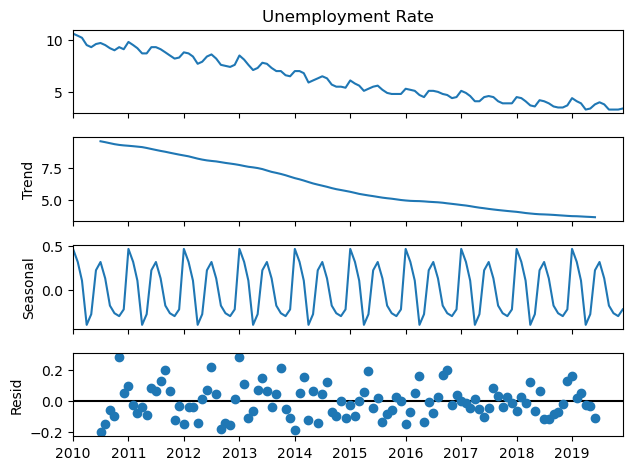

In [167]:
decomposition_results = seasonal_decompose(df_unem["unemp_rate"],
model="additive")
decomposition_results.plot().get_axes()[0].set_title('Unemployment Rate')


Looking at the distribution of residuals we can see that the mean is close to zero and it does not have a pattern, therefore the decomposition is good. The variance in the residuals is slightly higher in the first half of the dataset. This can indicate that a constant seasonal pattern is not good enough to accurately capture the seasonal component of the analyzed time series and a better model is needed. 

**Disadvantages of additive seasonal decomposition**

- As the algorithm uses centered moving averages to estimate the trend, running the decompo-
sition results in missing values of the trend line (and the residuals) at the very beginning and 
end of the time series.
-  The seasonal pattern estimated using this approach is assumed to repeat every year. It  is a very strong assumption, especially for longer time series.
-  The trend line has a tendency to over-smooth the data. 
-  The method is not robust to potential outliers in the data.

## STL decomposition


Seasonal-Trend decomposition using LOESS (STL) is a robust method for decomposing time series data into three main components: trend, seasonal, and residual (or remainder) components.

### Methodology

STL uses LOESS (locally estimated scatterplot smoothing) to perform the decomposition. The algorithm operates in two loops: the inner loop iterates between seasonal and trend smoothing, while the outer loop minimizes the effect of outliers. The seasonal component is calculated and removed first, followed by the trend component, and finally, the remainder is obtained.

### Advantages and Limitations

STL is versatile and can handle any type of seasonality, unlike other methods such as SEATS and X11, which are limited to monthly and quarterly data. It allows the seasonal component to change over time, and the rate of change can be controlled by the user. Additionally, STL is robust to outliers, ensuring that occasional unusual observations do not affect the estimates of the trend-cycle and seasonal components.

However, STL has some limitations, such as not automatically handling trading day or calendar variations and only supporting additive decompositions. Multiplicative decompositions can be achieved by transforming the data using a Box-Cox transformation.

Overall, STL decomposition is a powerful tool for analyzing time series data, allowing for the separation of underlying patterns from noise, which facilitates more accurate forecasting and analysis.



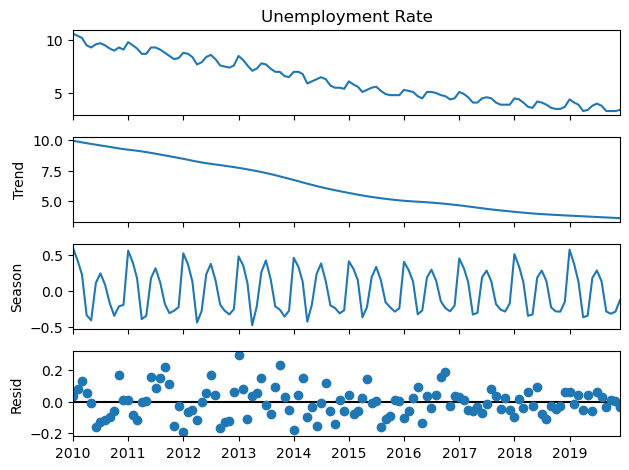

In [173]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Fit the STL decomposition
stl_decomposition = STL(df_unem["unemp_rate"]).fit()

# Plotting the decomposition
stl_decomposition.plot().get_axes()[0].set_title('Unemployment Rate')
plt.show()


STL and classical decompositions appear very similar. There are no missing values in the trend estimate at the beginning and end. The seasonal component is slowly changing over time. This is clear when focussing on data for one month for multiple years.

## Stationarity

The principle of weak stationarity states that for time series to be stationary: 

- The mean of the series must be constant
-  The variance of the series must be finite and constant
-  The covariance between periods of identical distance must be constant

Stationary is important when modeling the series using auto-regressive model (AR, ARMA, ARIMA, and so on). However, there are also models that do not benefit from stationary time series, for example, those that depend 
heavily on time series decomposition (exponential smoothing methods or Facebook’s Prophet).